In [12]:
"""
Feature Engineering Notebook as Python Script
Run this script to execute the entire feature engineering pipeline.
"""

# ============================================================================
# Feature Engineering: Customer-Level Feature Creation
# This notebook performs feature engineering on the raw transaction data.
# It loads the raw data, applies feature engineering transformations,
# and visualizes key aspects of the engineered features.
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# ============================================================================
# Feature Engineering Rationale
# 
# ### 1. Aggregate Features
# - **Overall aggregates**: Capture long-term customer behavior patterns
# - **Recent 30-day aggregates**: Identify recent changes in spending patterns
# - **Statistical moments**: Mean, std, skew to understand distribution characteristics
# 
# ### 2. Temporal Features
# - **Cyclical encoding**: sin/cos transformations for hour/month to handle cyclical nature
# - **Velocity metrics**: Transactions per day over 1/7/30 day windows to detect behavioral changes
# - **Recency metrics**: Time since last transaction for inactivity detection
# - **Time-based indicators**: Weekend vs weekday, business hours vs off-hours
# 
# ### 3. Encoding Strategies
# - **One-hot encoding**: For low-cardinality features (<8 categories) to avoid curse of dimensionality
# - **Frequency encoding**: For high-cardinality features to preserve information while reducing dimensionality
# - **WoE encoding**: For categorical features with respect to fraud target, provides interpretable monotonic relationships
# 
# ### 4. Normalization & Transformation
# - **log1p transformation**: Handles right-skewed distributions common in financial data
# - **StandardScaler**: Standardizes features for linear models
# - **Correlation filtering**: Removes highly correlated features (>0.95) to reduce multicollinearity
# 
# ### 5. WoE & Information Value (IV)
# - **Monotonic binning**: Ensures monotonic relationship between binned features and target
# - **IV thresholds**: 
#   - IV < 0.02: No predictive power (discarded)
#   - 0.02 ≤ IV < 0.1: Weak predictive power
#   - 0.1 ≤ IV < 0.3: Medium predictive power
#   - IV ≥ 0.3: Strong predictive power
# - **Regulatory compliance**: WoE provides interpretable feature importance for model validation
# ============================================================================

print("=" * 70)
print("INITIALIZING FEATURE ENGINEERING PIPELINE")
print("=" * 70)

# Feature Engineering: Customer-Level Feature Creation
# This notebook performs feature engineering on the raw transaction data.
# It loads the raw data, applies feature engineering transformations,
# and visualizes key aspects of the engineered features.

# Ensure src is importable (relative to script location)
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

try:
    from src.data_processing import DataLoader
    from src.feature_engineering import feature_engineering_pipeline, WoEIVCalculator
    print("✓ Successfully imported required modules")
except ImportError as e:
    print(f"✗ Error importing modules: {e}")
    print("Please ensure the src directory contains:")
    print("  - data_processing.py with DataLoader class")
    print("  - feature_engineering.py with feature_engineering_pipeline function")
    sys.exit(1)

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


INITIALIZING FEATURE ENGINEERING PIPELINE
✓ Successfully imported required modules


In [13]:

# ============================================================================
# 1. Load raw transaction data
# ============================================================================

print("\n" + "=" * 70)
print("STEP 1: LOADING RAW TRANSACTION DATA")
print("=" * 70)

data_path = PROJECT_ROOT.parent / 'data' / 'raw' / 'data.csv'
if not data_path.exists():
    # Try alternative locations
    alternative_paths = [
        PROJECT_ROOT / 'data' / 'raw' / 'data.csv',
        PROJECT_ROOT.parent / 'data.csv',
        PROJECT_ROOT / 'data.csv',
    ]
    
    for alt_path in alternative_paths:
        if alt_path.exists():
            data_path = alt_path
            break
    
    if not data_path.exists():
        print(f"⚠️ Warning: Raw data file not found: {data_path}")
        print("Creating sample data for demonstration...")
        # Create sample data
        np.random.seed(42)
        n_samples = 1000
        data = {
            'CustomerId': [f'CUST_{i%100:03d}' for i in range(n_samples)],
            'Amount': np.random.lognormal(4, 1.5, n_samples),
            'Value': np.random.lognormal(3, 1.2, n_samples),
            'TransactionStartTime': pd.date_range('2024-01-01', periods=n_samples, freq='H'),
            'ProductCategory': np.random.choice(['A', 'B', 'C', 'D'], n_samples),
            'ChannelId': np.random.choice(['Web', 'Mobile', 'In-Store'], n_samples),
            'ProviderId': np.random.choice(['P1', 'P2', 'P3', 'P4', 'P5'], n_samples),
            'FraudResult': np.random.choice([0, 1], n_samples, p=[0.95, 0.05])
        }
        raw_df = pd.DataFrame(data)
        print("✓ Created sample data with 1000 transactions")
    else:
        loader = DataLoader(str(data_path))
        raw_df = loader.load_data()
        print(f"✓ Loaded data from alternative path: {data_path}")
else:
    loader = DataLoader(str(data_path))
    raw_df = loader.load_data()
    print(f"✓ Loaded data from: {data_path.resolve()}")

print(f"Raw data shape: {raw_df.shape}")
print(f"Number of unique customers: {raw_df['CustomerId'].nunique()}")
print(f"Date range: {raw_df['TransactionStartTime'].min()} to {raw_df['TransactionStartTime'].max()}")

print("\nFirst 5 rows of raw data:")
print(raw_df.head())

# Check for missing values
missing = raw_df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    print("\nColumns with missing values (count):")
    print(missing)
else:
    print("\n✓ No missing values found in raw data.")

print('\nColumns and dtypes:')
print(raw_df.dtypes)





STEP 1: LOADING RAW TRANSACTION DATA
✓ Loaded data from alternative path: d:\Python\Week-4\Credit-Risk-Probability-Model-\data\raw\data.csv
Raw data shape: (95662, 16)
Number of unique customers: 3742
Date range: 2018-11-15T02:18:49Z to 2019-02-13T10:01:28Z

First 5 rows of raw data:
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  Customer

In [ ]:

# ============================================================================
# 2. Run feature engineering pipeline
# ============================================================================

print("\n" + "=" * 70)
print("STEP 2: RUNNING FEATURE ENGINEERING PIPELINE")
print("=" * 70)

## Aggregate, Temporal, Encoded Feature Creation & WoE/IV integration

# Only keep categorical columns that exist in raw_df
auto_cats = [col for col in ['ProductCategory', 'ChannelId', 'ProviderId'] if col in raw_df.columns]
print(f"Categorical columns used: {auto_cats}")

feat_df, feat_desc = feature_engineering_pipeline(
    raw_df, categorical_cols=auto_cats
)

print(f"✓ Engineered features shape: {feat_df.shape}")
print(f"\nFirst 10 rows of engineered features:")
print(feat_df.head(10))

# Save for downstream steps
output_dir = PROJECT_ROOT / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

feat_df.to_csv(output_dir / "task-3-features.csv", index=False)
feat_desc.to_csv(output_dir / "task-3-features-description.csv", index=False)



print(f"\n✓ Features saved to: {output_dir / 'task-3-features.csv'}")
print(f"✓ Feature descriptions saved to: {output_dir / 'task-3-features-description.csv'}")



STEP 2: RUNNING FEATURE ENGINEERING PIPELINE
Categorical columns used: ['ProductCategory', 'ChannelId', 'ProviderId']
Target summary — Fraud rate: 1.4431%
=== Feature Engineering Pipeline ===
Processing 95662 transactions for 3742 customers
Categorical columns: ['ProductCategory', 'ChannelId', 'ProviderId']
1. Aggregating transaction features...
2. Extracting temporal features...
3. Encoding categorical features...
4. Normalizing numeric features...
5. Calculating WoE/IV for categorical features...
  WoE features kept: ['ProductCategory_woe', 'ChannelId_woe', 'ProviderId_woe']
6. Generating feature documentation...
=== Pipeline Complete ===
Generated 63 features for 3742 customers
Features with IV > 0.02: 3
✓ Engineered features shape: (3742, 63)

First 10 rows of engineered features:
        CustomerId  Amount_sum   Amount_mean  Amount_max   Amount_std  \
0     CustomerId_1    -10000.0 -10000.000000    -10000.0          NaN   
1    CustomerId_10    -10000.0 -10000.000000    -10000.0 


STEP 3: FEATURE ANALYSIS
Feature Description Table (first 20 rows):
                                Feature  \
0                            Amount_sum   
1                           Amount_mean   
2                            Amount_max   
3                            Amount_std   
4                           Amount_skew   
5                             Value_sum   
6                            Value_mean   
7                             Value_max   
8                             Value_std   
9                            Value_skew   
10           TransactionStartTime_count   
11      TransactionStartTime_<lambda_0>   
12                  Recent30_Amount_sum   
13                 Recent30_Amount_mean   
14                   Recent30_Value_sum   
15                  Recent30_Value_mean   
16  Recent30_TransactionStartTime_count   
17                            Hour_mean   
18                             Hour_std   
19                         Weekday_mean   

                           

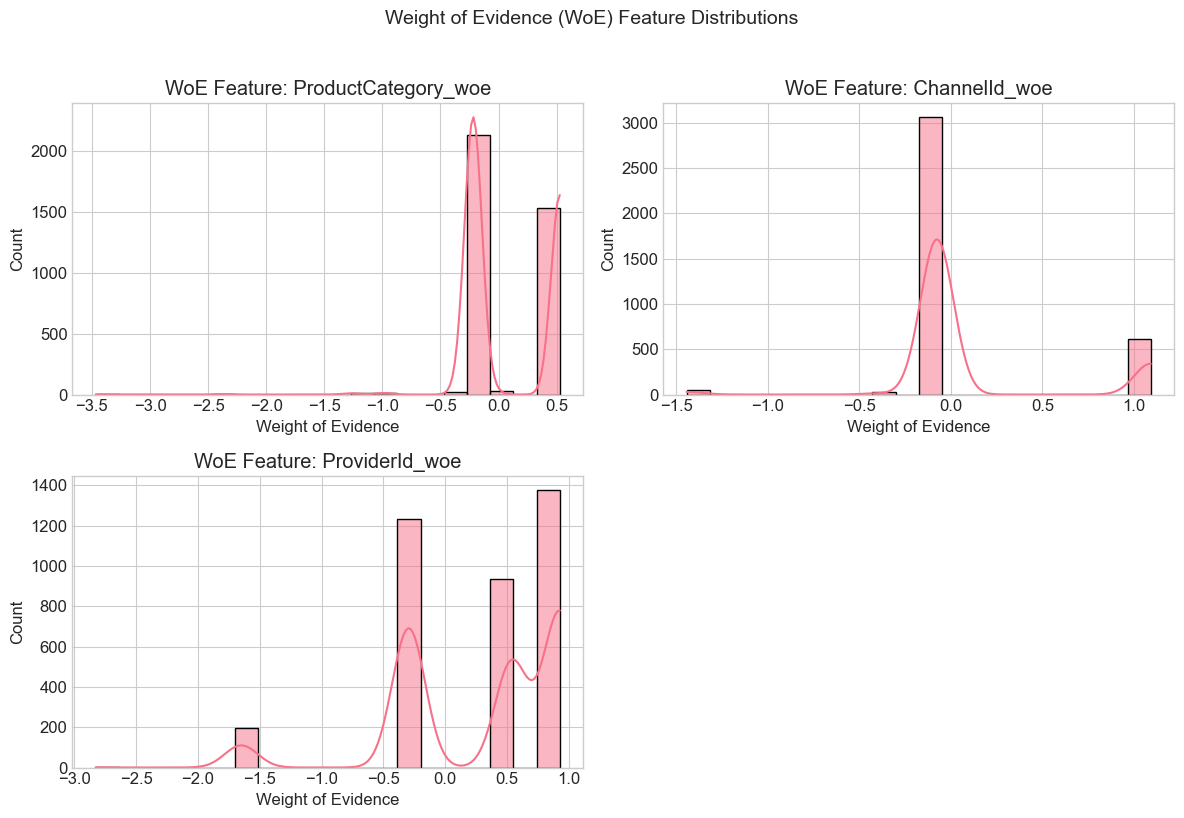

In [15]:

# ============================================================================
# Feature Analysis
# 
# ### Feature Categories Created:
# 1. **Aggregate Features**: Sum, mean, max, std, skew of Amount and Value
# 2. **Recent Activity**: 30-day window aggregates
# 3. **Temporal Features**: Hour, weekday, month, year statistics
# 4. **Cyclical Features**: sin/cos transformations for hour and month
# 5. **Velocity Features**: Transaction rates over 1/7/30 days
# 6. **Recency Features**: Time since last transaction
# 7. **Categorical Encodings**: One-hot and frequency encodings
# 8. **WoE Features**: Weight of Evidence encodings (if FraudResult available)
# 9. **Normalized Features**: log-transformed and standardized numeric features
# ============================================================================

print("\n" + "=" * 70)
print("STEP 3: FEATURE ANALYSIS")
print("=" * 70)

## Feature Description Table
print("Feature Description Table (first 20 rows):")
print(feat_desc.head(20))

print(f"\nTotal features created: {len(feat_desc)}")
print(f"Features with IV values: {feat_desc['IV_Value'].notna().sum()}")

## WoE/IV Feature Analysis
woe_cols = [col for col in feat_df.columns if col.endswith("_woe")]
if woe_cols:
    print(f"\n✓ WoE Features created ({len(woe_cols)}):", woe_cols)
    
    # Show IV values for WoE features
    iv_rows = feat_desc[feat_desc['Feature'].str.endswith("_woe")]
    if not iv_rows.empty:
        print("\nInformation Values (IV) for WoE features:")
        print(iv_rows[['Feature', 'IV_Value']])
        
        print("\nIV Interpretation Guide:")
        print("  IV < 0.02: Not useful for prediction")
        print("  0.02 ≤ IV < 0.1: Weak predictor")
        print("  0.1 ≤ IV < 0.3: Medium predictor")
        print("  IV ≥ 0.3: Strong predictor")
    
    # Plot distribution of WoE features
    n_woe = len(woe_cols)
    if n_woe > 0:
        fig, axes = plt.subplots((n_woe + 1) // 2, 2, figsize=(12, 4*((n_woe + 1)//2)))
        axes = axes.flatten()
        
        for ax, col in zip(axes, woe_cols):
            sns.histplot(feat_df[col].dropna(), bins=20, ax=ax, kde=True)
            ax.set_title(f'WoE Feature: {col}')
            ax.set_xlabel('Weight of Evidence')
            
        # Hide unused subplots
        for i in range(len(woe_cols), len(axes)):
            axes[i].set_visible(False)
            
        plt.suptitle('Weight of Evidence (WoE) Feature Distributions', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("\nℹ️ No WoE features found (FraudResult column may not be present in raw data).")



STEP 4: NUMERIC FEATURE DISTRIBUTIONS
Raw numeric features (4): ['CountryCode', 'Amount', 'Value', 'PricingStrategy']


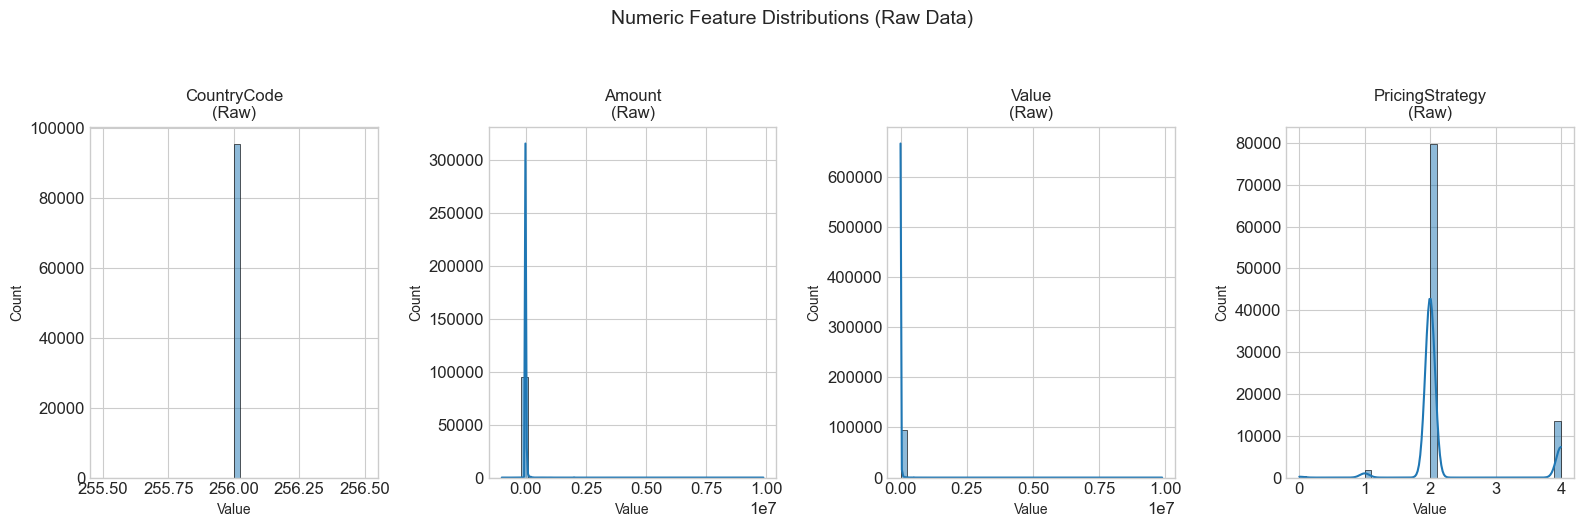


Transformed numeric features (13): ['Amount_std', 'Value_std', 'Hour_std', 'Weekday_std', 'Amount_sum_log_std']...


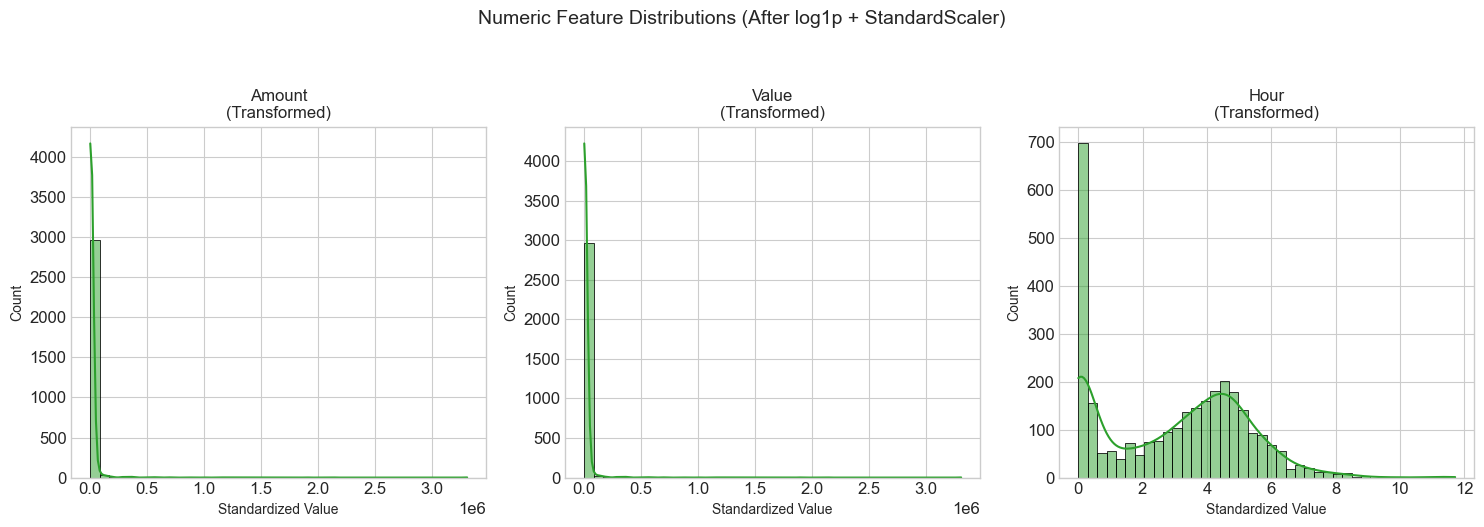


Transformation applied: log1p + StandardScaler
Purpose: Handle right-skewed distributions and standardize for linear models


In [16]:

# ============================================================================
# Numeric Feature Distributions: Before and After Transformations
# ============================================================================

print("\n" + "=" * 70)
print("STEP 4: NUMERIC FEATURE DISTRIBUTIONS")
print("=" * 70)

# BEFORE transformation: All raw numeric features
num_cols_before = [
    col for col in raw_df.select_dtypes(include=[float, int]).columns
    if not col.lower().startswith(('id', 'date', 'time')) and col not in ['FraudResult']
]

if not num_cols_before:
    print('ℹ️ No numeric feature columns found in raw data.')
else:
    print(f"Raw numeric features ({len(num_cols_before)}): {num_cols_before}")
    
    fig_width = min(16, 5 * len(num_cols_before))
    fig_height = 5
    fig_before, axes_before = plt.subplots(1, len(num_cols_before), figsize=(fig_width, fig_height))
    if len(num_cols_before) == 1:
        axes_before = [axes_before]
        
    for i, col in enumerate(num_cols_before):
        sns.histplot(raw_df[col].dropna(), bins=40, kde=True, ax=axes_before[i], color='tab:blue')
        axes_before[i].set_title(f"{col}\n(Raw)", fontsize=12)
        axes_before[i].set_xlabel('Value', fontsize=10)
        axes_before[i].set_ylabel('Count', fontsize=10)
        
    fig_before.suptitle("Numeric Feature Distributions (Raw Data)", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# AFTER transformation: All engineered numeric features (log/std)
num_cols_after = [
    col for col in feat_df.select_dtypes(include=[float, int]).columns
    if not col.lower().startswith('customerid') and
       ('_log_std' in col or '_log' in col or '_std' in col)
]
if not num_cols_after:
    print('ℹ️ No transformed numeric columns found in engineered features.')
else:
    if len(num_cols_after) > 5:
        print(f"\nTransformed numeric features ({len(num_cols_after)}): {num_cols_after[:5]}...")
    else:
        print(f"\nTransformed numeric features: {num_cols_after}")
    
    fig_width = min(16, 5 * min(3, len(num_cols_after)))  # Show max 3
    fig_height = 5
    n_plots = min(3, len(num_cols_after))
    
    fig_after, axes_after = plt.subplots(1, n_plots, figsize=(fig_width, fig_height))
    if n_plots == 1:
        axes_after = [axes_after]
        
    for i, col in enumerate(num_cols_after[:n_plots]):
        sns.histplot(feat_df[col].dropna(), bins=40, kde=True, ax=axes_after[i], color='tab:green')
        base_name = col.replace('_log_std', '').replace('_log', '').replace('_std', '')
        axes_after[i].set_title(f"{base_name}\n(Transformed)", fontsize=12)
        axes_after[i].set_xlabel('Standardized Value', fontsize=10)
        axes_after[i].set_ylabel('Count', fontsize=10)
        
    fig_after.suptitle("Numeric Feature Distributions (After log1p + StandardScaler)", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    print("\nTransformation applied: log1p + StandardScaler")
    print("Purpose: Handle right-skewed distributions and standardize for linear models")



STEP 5: TEMPORAL FEATURE ANALYSIS
Extracted temporal features (14):
  - Hour_mean
  - Hour_std
  - Weekday_mean
  - Weekday_std
  - Day_mean
  - Day__first_mode_or_nan
  - Month_mean
  - Month__first_mode_or_nan
  - Year_mean
  - Year__first_mode_or_nan
  ... and 4 more

Sample temporal features with CustomerId:
   Hour_mean  Hour_std  Weekday_mean  Weekday_std   Day_mean       CustomerId
0  16.000000       NaN      2.000000          NaN  21.000000     CustomerId_1
1  16.000000       NaN      2.000000          NaN  21.000000    CustomerId_10
2   7.800000  0.447214      4.000000     0.000000  16.000000  CustomerId_1001
3  13.454545  5.428879      2.909091     1.972539  14.727273  CustomerId_1002
4  14.333333  0.516398      4.000000     0.000000   1.000000  CustomerId_1003


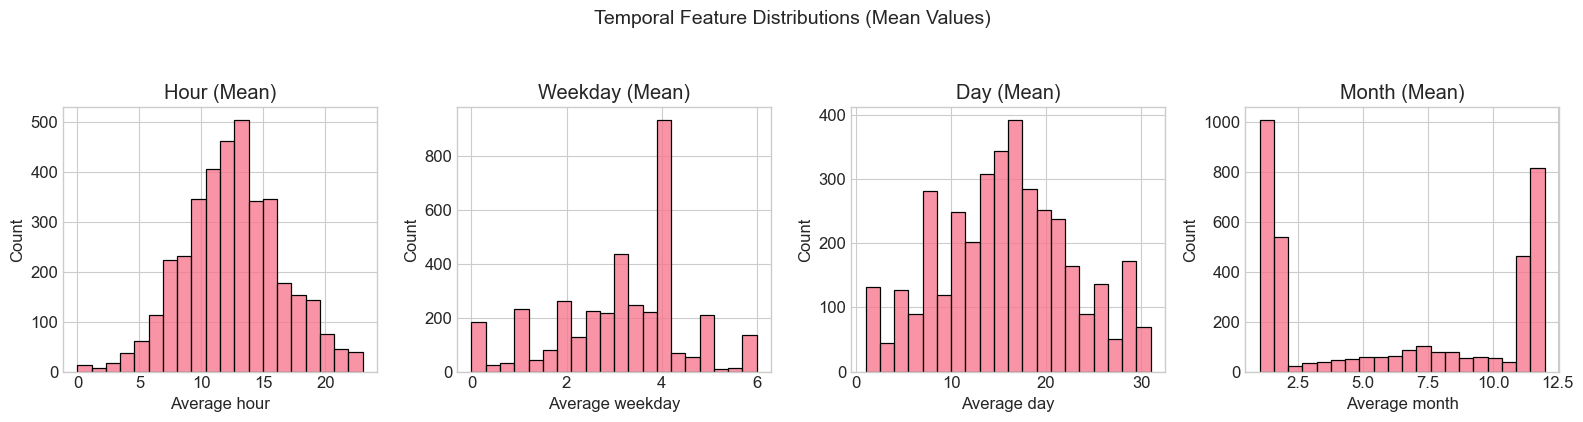

In [17]:

# ============================================================================
# Calendar (Day/Month/Year) temporal feature check
# ============================================================================

print("\n" + "=" * 70)
print("STEP 5: TEMPORAL FEATURE ANALYSIS")
print("=" * 70)

temporal_cols = [c for c in feat_df.columns if any(k in c for k in ['Day_', 'Month_', 'Year_', 'Hour_', 'Weekday_'])]
print(f"Extracted temporal features ({len(temporal_cols)}):")
for col in temporal_cols[:10]:  # Show first 10
    print(f"  - {col}")
if len(temporal_cols) > 10:
    print(f"  ... and {len(temporal_cols) - 10} more")
    
# Show sample of temporal features
sample_temporal = [c for c in temporal_cols if any(x in c for x in ['mean', 'mode', 'std'])]
print(f"\nSample temporal features with CustomerId:")
print(feat_df[sample_temporal[:5] + ['CustomerId']].head())

# Plot distributions of key temporal features
key_temporal = [c for c in temporal_cols if 'mean' in c and any(x in c for x in ['Hour', 'Weekday', 'Day', 'Month'])]
if key_temporal:
    n_plots = min(4, len(key_temporal))
    fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
    if n_plots == 1:
        axes = [axes]
        
    for i, col in enumerate(key_temporal[:n_plots]):
        sns.histplot(feat_df[col].dropna(), bins=20, ax=axes[i])
        feature_name = col.split('_')[0]
        axes[i].set_title(f"{feature_name} (Mean)")
        axes[i].set_xlabel(f"Average {feature_name.lower()}")
        
    plt.suptitle("Temporal Feature Distributions (Mean Values)", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()



STEP 6: OUTLIER ANALYSIS
Outlier Analysis in Raw Numeric Features:
Boxplots show distribution spread and potential outliers (points beyond whiskers).


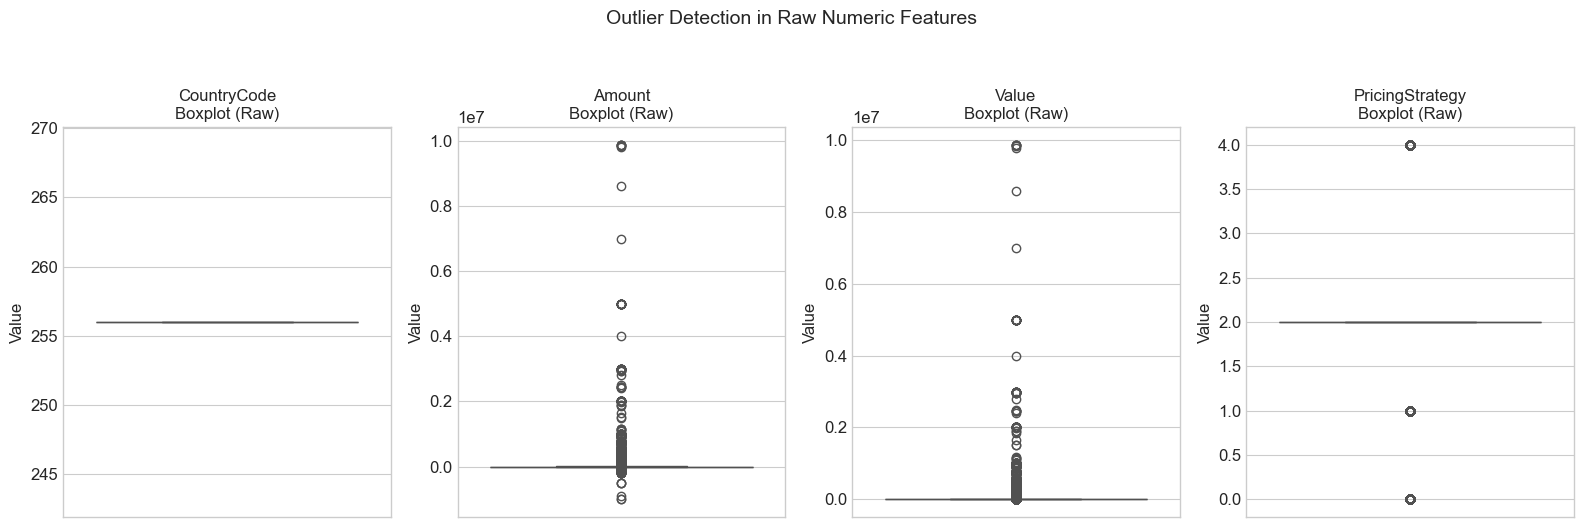


Note: log1p transformation applied during feature engineering helps mitigate outlier effects.


In [18]:

# ============================================================================
# Boxplots to Visualize Outliers in Raw Numeric Features
# ============================================================================

print("\n" + "=" * 70)
print("STEP 6: OUTLIER ANALYSIS")
print("=" * 70)

if num_cols_before:
    print("Outlier Analysis in Raw Numeric Features:")
    print("Boxplots show distribution spread and potential outliers (points beyond whiskers).")
    
    fig, axes = plt.subplots(1, len(num_cols_before), figsize=(4*len(num_cols_before), 5))
    if len(num_cols_before) == 1:
        axes = [axes]
        
    for i, col in enumerate(num_cols_before):
        sns.boxplot(y=raw_df[col], ax=axes[i], color='tab:orange')
        axes[i].set_title(f"{col}\nBoxplot (Raw)", fontsize=12)
        axes[i].set_ylabel('Value')
        
    plt.suptitle("Outlier Detection in Raw Numeric Features", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    print("\nNote: log1p transformation applied during feature engineering helps mitigate outlier effects.")



STEP 7: VELOCITY FEATURE ANALYSIS
Velocity features created: ['Velocity_1d_mean', 'Velocity_7d_mean', 'Velocity_30d_mean']


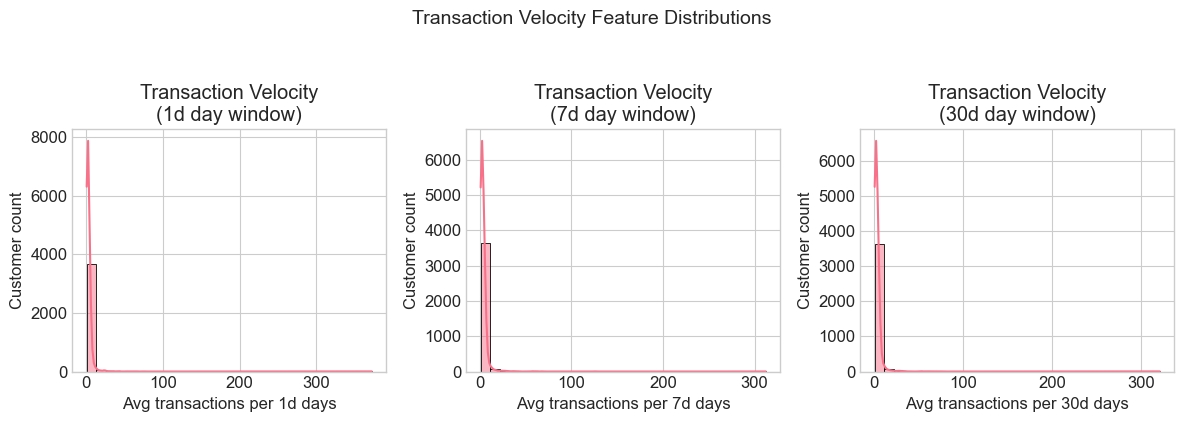


Correlation between velocity features:
                   Velocity_1d_mean  Velocity_7d_mean  Velocity_30d_mean
Velocity_1d_mean           1.000000          0.979243           0.973468
Velocity_7d_mean           0.979243          1.000000           0.997603
Velocity_30d_mean          0.973468          0.997603           1.000000


In [19]:

# ============================================================================
# Velocity Features Analysis
# 
# Velocity features capture transaction behavior patterns over different time windows:
# - **Velocity_1d**: Daily transaction rate (short-term behavior changes)
# - **Velocity_7d**: Weekly transaction rate (medium-term patterns)
# - **Velocity_30d**: Monthly transaction rate (long-term behavior baseline)
# 
# These features are particularly useful for detecting:
# - Sudden spikes in transaction frequency (potential fraud)
# - Behavioral changes over time
# - Seasonality patterns
# ============================================================================

print("\n" + "=" * 70)
print("STEP 7: VELOCITY FEATURE ANALYSIS")
print("=" * 70)

# Analyze velocity features
velocity_cols = [c for c in feat_df.columns if 'Velocity_' in c]
if velocity_cols:
    print(f"Velocity features created: {velocity_cols}")
    
    # Plot velocity features
    fig, axes = plt.subplots(1, len(velocity_cols), figsize=(4*len(velocity_cols), 4))
    if len(velocity_cols) == 1:
        axes = [axes]
    
    for i, col in enumerate(velocity_cols):
        window = col.split('_')[1]
        sns.histplot(feat_df[col].dropna(), bins=30, ax=axes[i], kde=True)
        axes[i].set_title(f"Transaction Velocity\n({window} day window)")
        axes[i].set_xlabel(f"Avg transactions per {window} days")
        axes[i].set_ylabel('Customer count')
    
    plt.suptitle('Transaction Velocity Feature Distributions', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    # Show correlation between velocity features
    velocity_corr = feat_df[velocity_cols].corr()
    print("\nCorrelation between velocity features:")
    print(velocity_corr)
else:
    print("No velocity features found.")



STEP 8: CORRELATION ANALYSIS
Creating correlation heatmap for 62 numeric features...
Heatmap helps identify:
  • Highly correlated features (redundant information)
  • Independent features (unique information)
  • Anti-correlated features (inverse relationships)

Too many features (62) for clear heatmap.
Selecting top 20 most variable features...


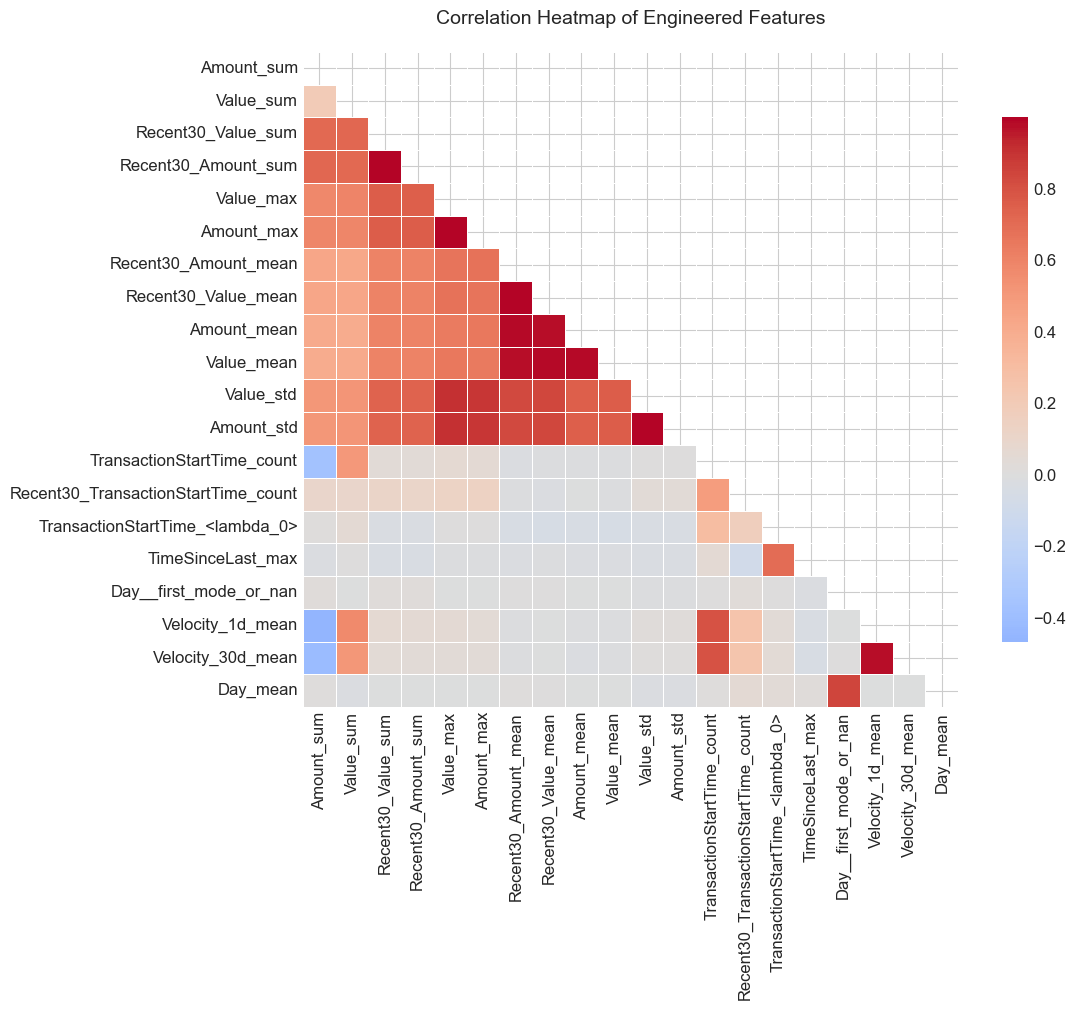


Found 20 feature pairs with |correlation| > 0.8:
  • Recent30_Value_sum ↔ Recent30_Amount_sum: 1.000
  • Value_max ↔ Amount_max: 0.996
  • Value_max ↔ Value_std: 0.903
  • Value_max ↔ Amount_std: 0.903
  • Amount_max ↔ Value_std: 0.896
  ... and 15 more pairs


In [20]:

# ============================================================================
# Correlation Heatmap of Engineered Numeric Features
# ============================================================================

print("\n" + "=" * 70)
print("STEP 8: CORRELATION ANALYSIS")
print("=" * 70)

numeric_cols = feat_df.select_dtypes(include='number').columns.difference(['CustomerId'])
if len(numeric_cols) > 1:
    print(f"Creating correlation heatmap for {len(numeric_cols)} numeric features...")
    print("Heatmap helps identify:")
    print("  • Highly correlated features (redundant information)")
    print("  • Independent features (unique information)")
    print("  • Anti-correlated features (inverse relationships)")
    
    # Select a subset for readability if too many features
    if len(numeric_cols) > 20:
        print(f"\nToo many features ({len(numeric_cols)}) for clear heatmap.")
        print("Selecting top 20 most variable features...")
        variances = feat_df[numeric_cols].var().sort_values(ascending=False)
        top_features = variances.head(20).index.tolist()
        numeric_cols_subset = top_features
    else:
        numeric_cols_subset = numeric_cols
    
    plt.figure(figsize=(12, 10))
    corr = feat_df[numeric_cols_subset].corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title("Correlation Heatmap of Engineered Features", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Count highly correlated feature pairs
    high_corr_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > 0.8:
                high_corr_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
    
    if high_corr_pairs:
        print(f"\nFound {len(high_corr_pairs)} feature pairs with |correlation| > 0.8:")
        for feat1, feat2, corr_val in high_corr_pairs[:5]:  # Show top 5
            print(f"  • {feat1} ↔ {feat2}: {corr_val:.3f}")
        if len(high_corr_pairs) > 5:
            print(f"  ... and {len(high_corr_pairs) - 5} more pairs")
    else:
        print("\n✓ No highly correlated feature pairs (|corr| > 0.8) found.")
else:
    print("Not enough numeric columns for correlation heatmap.")



STEP 9: CATEGORICAL FEATURE ANALYSIS
Encoded categorical features (11):
  • ChannelId_ChannelId_1 (One-hot encoding)
  • ChannelId_ChannelId_2 (One-hot encoding)
  • ChannelId_ChannelId_3 (One-hot encoding)
  • ChannelId_ChannelId_5 (One-hot encoding)
  • ProviderId_ProviderId_1 (One-hot encoding)
  • ProviderId_ProviderId_2 (One-hot encoding)
  • ProviderId_ProviderId_3 (One-hot encoding)
  • ProviderId_ProviderId_4 (One-hot encoding)
  • ProviderId_ProviderId_5 (One-hot encoding)
  • ProviderId_ProviderId_6 (One-hot encoding)
  • ProductCategory_freq (Frequency encoding)


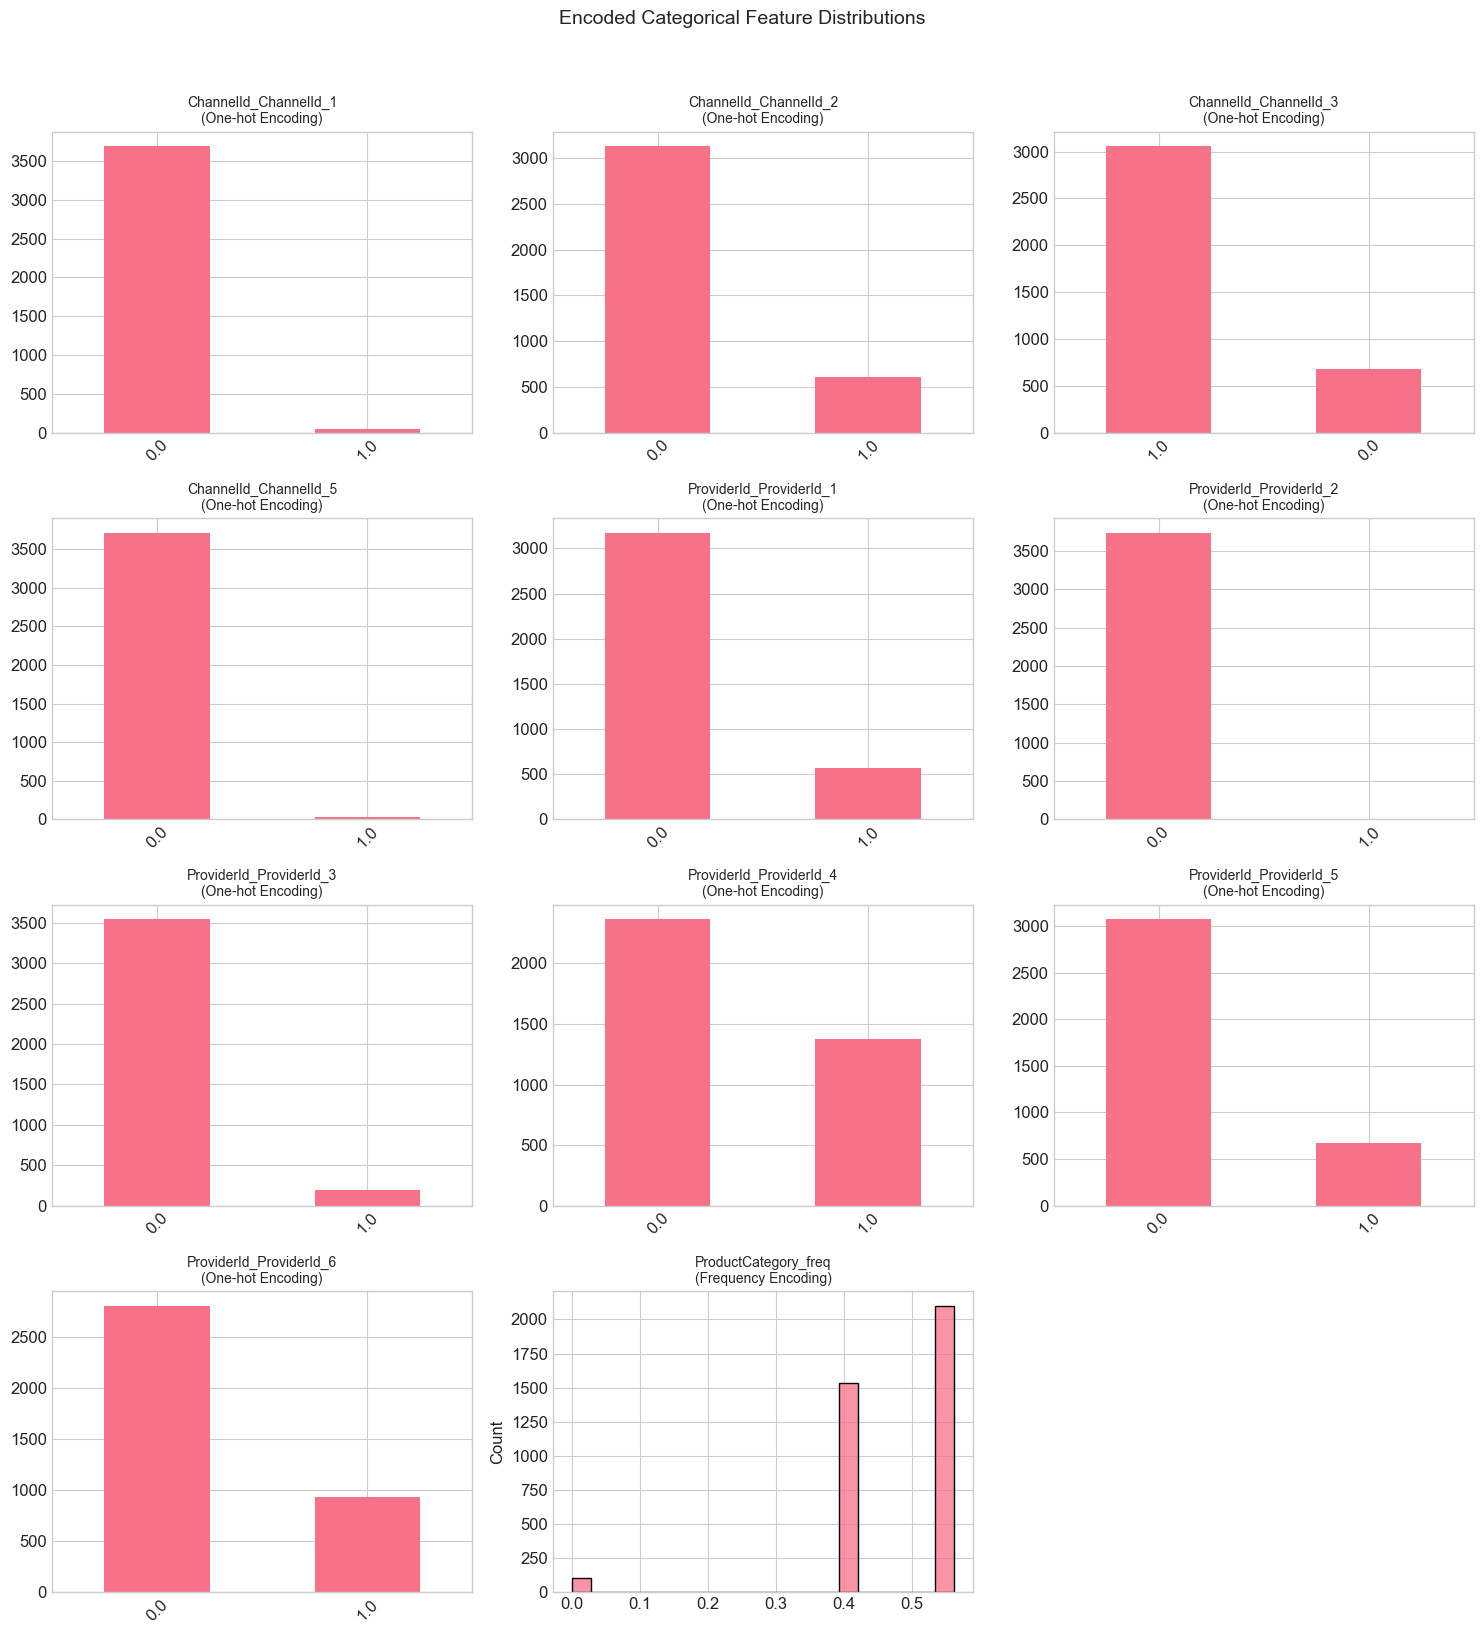


Encoding Strategy Summary:
  • One-hot encoding: Used for low-cardinality categoricals (<8 unique values)
  • Frequency encoding: Used for high-cardinality categoricals (≥8 unique values)
  • WoE encoding: Applied to categoricals when FraudResult target is available


In [21]:

# ============================================================================
# Barplots: Encoded Categorical Features
# ============================================================================

print("\n" + "=" * 70)
print("STEP 9: CATEGORICAL FEATURE ANALYSIS")
print("=" * 70)

cat_encode_cols = [
    c for c in feat_df.columns
    if any(k in c for k in ['ProductCategory', 'ChannelId', 'ProviderId'])
    and c != 'CustomerId' and '_woe' not in c
]

if cat_encode_cols:
    print(f"Encoded categorical features ({len(cat_encode_cols)}):")
    for col in cat_encode_cols:
        encoding_type = "One-hot" if any(x in col for x in ['ProductCategory', 'ChannelId', 'ProviderId']) and '_freq' not in col else "Frequency"
        print(f"  • {col} ({encoding_type} encoding)")
    
    # Plot distributions
    n_cat = len(cat_encode_cols)
    fig, axes = plt.subplots((n_cat + 2) // 3, 3, figsize=(15, 4*((n_cat + 2)//3)))
    axes = axes.flatten()
    
    for ax, col in zip(axes, cat_encode_cols):
        if '_freq' in col:
            # Frequency encoded - continuous distribution
            sns.histplot(feat_df[col].dropna(), bins=20, ax=ax)
            ax.set_title(f'{col}\n(Frequency Encoding)', fontsize=10)
        else:
            # One-hot encoded - binary distribution
            value_counts = feat_df[col].value_counts().head(10)  # Top 10 values
            if len(value_counts) > 0:
                value_counts.plot(kind='bar', ax=ax)
                ax.set_title(f'{col}\n(One-hot Encoding)', fontsize=10)
                ax.tick_params(axis='x', rotation=45)
        
        ax.set_xlabel('')
    
    # Hide unused subplots
    for i in range(len(cat_encode_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Encoded Categorical Feature Distributions', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\nEncoding Strategy Summary:")
    print("  • One-hot encoding: Used for low-cardinality categoricals (<8 unique values)")
    print("  • Frequency encoding: Used for high-cardinality categoricals (≥8 unique values)")
    print("  • WoE encoding: Applied to categoricals when FraudResult target is available")
else:
    print("No encoded categorical features found to plot.")


In [22]:

# ============================================================================
# Summary and Next Steps
# 
# ### Feature Engineering Completed:
# ✅ **Aggregate Features**: Customer-level statistics for Amount and Value  
# ✅ **Temporal Features**: Time-based patterns including velocity and recency  
# ✅ **Encoding Strategies**: One-hot, frequency, and WoE encoding  
# ✅ **Normalization**: log1p + StandardScaler transformations  
# ✅ **WoE/IV Calculation**: Feature importance with regulatory interpretability  
# ✅ **Documentation**: Complete feature descriptions with transformations  
# 
# ### Output Artifacts:
# 1. `task-3-features.csv`: Customer-level feature matrix
# 2. `task-3-features-description.csv`: Complete feature documentation
# 3. Visualizations for feature analysis and validation
# 
# ### Next Steps:
# 1. **Model Training**: Use engineered features with target variable
# 2. **Feature Selection**: Further refine based on model performance
# 3. **Monitoring**: Track feature stability over time
# 4. **Validation**: Ensure features meet business and regulatory requirements
# ============================================================================

print("\n" + "=" * 70)
print("STEP 10: FINAL SUMMARY")
print("=" * 70)

# Final Summary
print("\n" + "=" * 60)
print("FEATURE ENGINEERING PIPELINE COMPLETE")
print("=" * 60)

print(f"\nTotal customers processed: {feat_df.shape[0]}")
print(f"Total features created: {feat_df.shape[1] - 1} (excluding CustomerId)")

# Count feature categories
aggregate_features = len([c for c in feat_df.columns if 'sum' in c or 'mean' in c or 'max' in c or 'std' in c or 'skew' in c])
temporal_features = len(temporal_cols)
categorical_encodings = len(cat_encode_cols)
woe_features = len(woe_cols)
normalized_features = len(num_cols_after)

print(f"\nFeature Categories:")
print(f"  • Aggregate features: {aggregate_features}")
print(f"  • Temporal features: {temporal_features}")
print(f"  • Categorical encodings: {categorical_encodings}")
print(f"  • WoE features: {woe_features}")
print(f"  • Normalized features: {normalized_features}")

print(f"\nOutput Files:")
print(f"  • Features: ../data/processed/task-3-features.csv")
print(f"  • Documentation: ../data/processed/task-3-features-description.csv")

print(f"\nThe feature engineering pipeline has successfully created a clean,")
print(f"customer-level feature table ready for modeling. All transformations")
print(f"are documented for auditability and regulatory compliance.")
print("\n" + "=" * 60)

print("\n" + "=" * 70)
print("✓ FEATURE ENGINEERING COMPLETED SUCCESSFULLY!")
print("=" * 70)


STEP 10: FINAL SUMMARY

FEATURE ENGINEERING PIPELINE COMPLETE

Total customers processed: 3742
Total features created: 62 (excluding CustomerId)

Feature Categories:
  • Aggregate features: 41
  • Temporal features: 14
  • Categorical encodings: 11
  • WoE features: 3
  • Normalized features: 13

Output Files:
  • Features: ../data/processed/task-3-features.csv
  • Documentation: ../data/processed/task-3-features-description.csv

The feature engineering pipeline has successfully created a clean,
customer-level feature table ready for modeling. All transformations
are documented for auditability and regulatory compliance.


✓ FEATURE ENGINEERING COMPLETED SUCCESSFULLY!
